# Libraries and Functions

In [1]:
#Arrays and containers
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import arviz as az

#Stats
from scipy import stats
import statsmodels.api as sm
from pingouin import power_chi2
import pymc as pm
import pytensor.tensor as pt
print('Running on PyMC v{}'.format(pm.__version__))



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.12.0


# A/B Testing
Santa Fe Grill decided to test its website with an A/B test. They measured the number of clicks in the site, the number of searches, the number of product views, the number of merchandise put in the cart, and the number of purchases.

Normality test  Test Campaign :  ShapiroResult(statistic=0.9181893816994644, pvalue=0.024077671296646546)
Normality test  Control Campaign :  ShapiroResult(statistic=0.938141969247496, pvalue=0.08964421284477991)


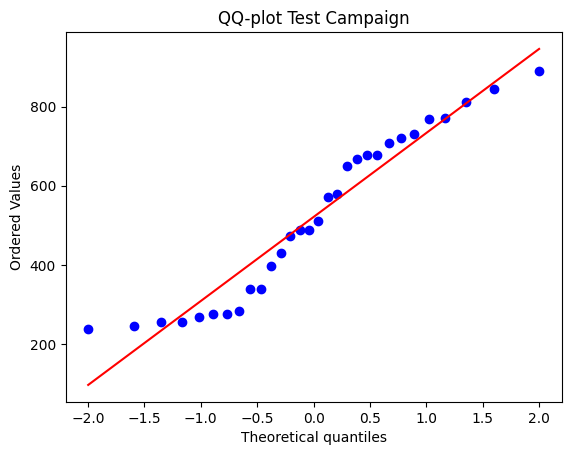

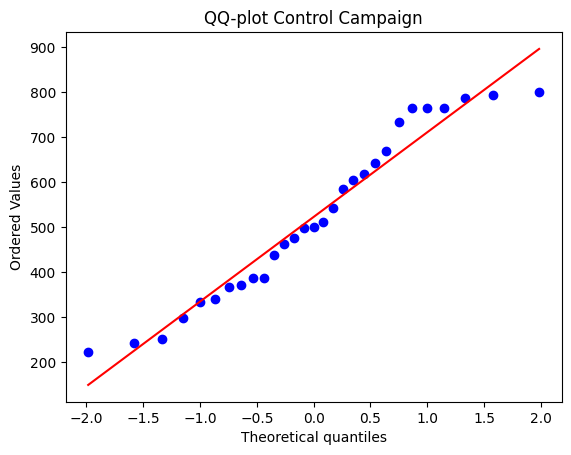

In [2]:
#Let´s check the assumptions
#First data setup
AB_website_test = pd.read_csv("AB_test_group.csv", sep = ";")
AB_website_control = pd.read_csv("AB_control_group.csv", sep = ";")
cols = ["Campaign", "Date", "Cost_Campaign", "n_Impresions", "Reach", 
        "n_Clicks", "n_Searches", "n_Views", "n_Cart", "n_Purchase"]
AB_website_test.columns = cols
AB_website_control.columns = cols
AB_website = pd.concat([AB_website_test, AB_website_control]).reset_index(drop=True)
AB_website.dropna(inplace = True)

#Now checks. Variable of interest n_Purchase
#Not discrete but with sufficient range.
#Now normality. Seems ok
campaigns = AB_website.loc[:,"Campaign"].unique()
idx_A = (AB_website.loc[:,"Campaign"] == campaigns[0])
idx_B = (AB_website.loc[:,"Campaign"] == campaigns[1])
Group_A = AB_website.loc[idx_A,"n_Purchase"]
Group_B = AB_website.loc[idx_B,"n_Purchase"]

stats.probplot(Group_A, plot = plt); 
plt.title("QQ-plot " + campaigns[0])
print("Normality test ", campaigns[0], ": ", stats.shapiro(Group_A)) #normality test, p<0.05 no normality


plt.figure()

stats.probplot(Group_B, plot = plt); 
plt.title("QQ-plot " + campaigns[1]);
print("Normality test ", campaigns[1], ": ", stats.shapiro(Group_B)) #normality test p<0.05 no normality



In [3]:
#Now variance.
#Seem slightly different but not much
print(AB_website.groupby(["Campaign"]).agg({'n_Purchase': ["mean", "std"]}))
print("\nLevene test for unequal variances")
print(stats.levene(Group_A, Group_B)) #p<0.05 different variances
print("\nt-tests for different means")
#Let´s do a traditional t test plus a t test that does not assume equal variances (Welch's t test)
#Both have a p>0.05. No difference in the mean.
print("Two sample t-test: ", stats.ttest_ind(Group_A, Group_B))
print("Welch's t-test: ", stats.ttest_ind(Group_A, Group_B, equal_var = False))


                  n_Purchase            
                        mean         std
Campaign                                
Control Campaign  522.793103  185.028642
Test Campaign     521.233333  211.047745

Levene test for unequal variances
LeveneResult(statistic=1.230260648051359, pvalue=0.2720142278811527)

t-tests for different means
Two sample t-test:  TtestResult(statistic=-0.03014479856562245, pvalue=0.9760568756579724, df=57.0)
Welch's t-test:  TtestResult(statistic=-0.030212884995111548, pvalue=0.9760037958073526, df=56.47307683626032)


### Exercise (A/B Testing)
Now let's work with a larger dataset (more than 500,000 observations/rows) [Source: click here](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing). 

Imagine this is a campaign that Amazon executed in Singapore to increase sales after being worried by the satisfaction levels of their clients. They tested their ad against another campaign. 

Index: Row index 

user id: User ID (unique)

test group: If "ad" the person saw the add, if "psa" only saw the public service announcement

converted: If a person bought the product then True, else is False

total ads: Amount of ads seen by person

most ads day: Day that the person saw the biggest amount of ads

most ads hour: Hour of day that the person saw the biggest amount of ads


1) Load marketing_AB.csv. Call it AB_marketing.
2) Drop the first column
3) Print data types
4) Change column names to: "ID", "Intervention", "Converted", "Total_Ads", "Most_Ads_Day", "Most_Ads_Hour"
5) Outlier detection.
   * Do a box plot with seaborn (https://seaborn.pydata.org/generated/seaborn.catplot.html)
   * Put whis = (2.5, 97.5) i.e. the whiskers cover 95% of the data
   * x = intervention, y = Total_Ads
   * Put the plot in a variable called bp
   * bp will have the y axis with a large range of values.
   * Change the y limits to better see the whisker limits, with bp.set(ylim=(lower, upper))...change lower or upper to your preference
6) Are there outliers beyond the whiskers?
   * Eyeball a threshold for outliers.
   * Drop all the rows with outliers (i.e. outside the eyeballed threshold) (remember .reset_index(drop = True))
   * Call the new dataset AB_marketing_no.
   * How many rows did you drop?
   * Bonus: Sort AB_marketing_no by Most_Ads_Day. This is to make the barplot below ordered as the days of the week
7) Outlier detection version 2.
   * Calculate the standard deviation of Total_Ads in the original AB_marketing.
   * Drop anything within 3 standard deviations.
   * Call the new data set AB_marketing_no_2
   * How many rows did you drop?
8) Barplot with AB_marketing_no. Tip: https://seaborn.pydata.org/generated/seaborn.catplot.html
   * Make two panels, in each panel the data of one intervention type.
   * Within each panel, put Most_Ads_Day in the x-axis.
   * What should go in the y axis (heights of the bars). Which variable do you think we are interested in?
   * What are the default error bars did seaborn used?
   * Justify why a barplot is interesting for EDA for this variable.
   * Change the title and any other change that you think will make the plot better.
   * What did you learn from this plot?



# Proportion Test (and effect sizes)

There are multiple alternatives to compare proportions. Given that we are focusing on A/B test, we will see the $\chi^2$ test (along with its effect size: Cohen's W) and for post-hoc comparisons the binomial test.

<h6> (another popular test is the z-test if we can assume that the proportions are normally distributed, see statsmodels.stats.proportion.proportions_ztest; also odds ratios, but in my opinion they are hard to interpret because they hide info)


In [4]:
#Load data
AB_marketing = pd.read_csv("marketing_AB.csv")

#Drop the first column
AB_marketing.drop(AB_marketing.columns[0], inplace = True, axis = "columns")

#Change column names
cols = ["ID", "Intervention", "Converted", "Total_Ads", "Most_Ads_Day", "Most_Ads_Hour"]
AB_marketing.columns = cols

#Count frequencies and total of converted in each intervention
#Freq = AB_marketing.groupby(["Intervention"]).agg({"ID":"count",
#                                                   "Converted":["sum", "mean"]})
Freq = AB_marketing.groupby(["Intervention", "Converted"]).agg({"ID":"count"}).reset_index()
Freq = Freq.pivot(columns = "Converted", values = "ID", index = "Intervention")#.reset_index()
#print(Freq)
Freq.reset_index().drop(Freq.columns[0:2], inplace = True, axis = "columns")
Freq = pd.DataFrame(np.array(Freq), 
                    index = ["Intervention_ad", "Intervention_psa"],
                    columns = ["Converted_No", "Converted_Yes"])
NO = np.array(Freq).sum(axis=0)[0]
YES = np.array(Freq).sum(axis=0)[1]
AD = np.array(Freq).sum(axis=1)[0]
PSA = np.array(Freq).sum(axis=1)[1]
TOTAL = NO+YES
print("Converted (avg)", YES/TOTAL, "\n") #Few people convert on average (regardless of campaign)

#Chi-Square test
res = stats.chi2_contingency(Freq) #the expected_freq is using only the marginals i.e. each cell is independent
#In case it is of interest, res.expected_freq manually:
#AD_No_e = AD*NO/TOTAL
#AD_Yes_e = AD*YES/TOTAL
#PSA_No_e = PSA*NO/TOTAL
#PSA_Yes_e = PSA*YES/TOTAL

print("Empirical rates: \n",
      "AD_no: ", Freq.iloc[0,0]/AD, "\n", 
      "AD_yes: ", Freq.iloc[0,1]/AD, "\n", 
      "PSA_no: ", Freq.iloc[1,0]/PSA, "\n", 
      "PSA_yes: ", Freq.iloc[1,1]/PSA, "\n")
print("Hypothesized rates (rates are independent of campaign): \n",
      "AD_no: ", NO/TOTAL, "\n", 
      "AD_yes: ", YES/TOTAL, "\n", 
      "PSA_no: ", NO/TOTAL, "\n", 
      "PSA_yes: ", YES/TOTAL, "\n")

print("Chi square test p val: ", res.pvalue) #p<0.05: reject the null of independence. The frequencies are not independent of the intervention i.e. the intervention matters
print("Effect size (Cohen's W): %.4f" % power_chi2(dof=1, n=Freq.sum().sum(), power=0.80, alpha=0.05)) #small effect: w = 0.10; medium effect: w = 0.30; large effect: w = 0.50.

#Binomial test:
#Could be useful for post-hoc evaluations of the chi square test
binom_AD_no = stats.binomtest(Freq.iloc[0,0], AD, p=NO/TOTAL, alternative='two-sided')
binom_AD_yes = stats.binomtest(Freq.iloc[0,1], AD, p=YES/TOTAL, alternative='two-sided')
binom_PSA_no = stats.binomtest(Freq.iloc[1,0], AD, p=NO/TOTAL, alternative='two-sided')
binom_PSA_yes = stats.binomtest(Freq.iloc[1,1], AD, p=YES/TOTAL, alternative='two-sided')
#multiple comparisons corrections
pvals = sm.stats.multipletests([binom_AD_no.pvalue, binom_AD_yes.pvalue,
                                binom_PSA_no.pvalue, binom_PSA_yes.pvalue])
print("\nPost-hoc binomial test (corrected p values for multiple comparisons): ", 
      pvals[1], "\nPSA seems to be the one with lower yes convertions") 

Converted (avg) 0.02523886203220195 

Empirical rates: 
 AD_no:  0.9744534403633163 
 AD_yes:  0.025546559636683747 
 PSA_no:  0.9821458935555177 
 PSA_yes:  0.01785410644448223 

Hypothesized rates (rates are independent of campaign): 
 AD_no:  0.9747611379677981 
 AD_yes:  0.02523886203220195 
 PSA_no:  0.9747611379677981 
 PSA_yes:  0.02523886203220195 

Chi square test p val:  1.9989623063390075e-13
Effect size (Cohen's W): 0.0037

Post-hoc binomial test (corrected p values for multiple comparisons):  [0.2620778 0.2620778 0.        0.       ] 
PSA seems to be the one with lower yes convertions


# A/B more than two groups
This image ([source: Brian O´Gorman](https://github.com/brian-c-ogorman/ABanditTesting/)) has four groups during testing. The best group ends up being 1 and is selected/exploited henceforth. Thus, all the remaining groups experienced suboptimal options (regret) during the test/exploratory phase (assuming randomization).

<img src="A-B_Test.png" width="600"/>

For instance, the 4 options could be different movies. The platform, say Netflix, wants to determine what to recommend to some users with shared characteristics. Netflix then does A/B testing, meaning, user pool 1 watches movie 1, user pool 2 watches movie 2, and so forth. Asumming perfect comparability between the 4 user pools, Netflix finds that movie 1 got higher scores (in binary, more 5 out of 5 because for sure they liked it). The other groups spent time with suboptimal movies, and just got movie 1 in their feed after the A/B test.

How do we know, statistically, that the proportion of 5 out of 5 is indeed larger than the other groups? 




Index(['Unnamed: 0.1', 'Unnamed: 0', 'Sampled_Day', 'user_id', 'movie_id',
       'rating', 'movie_title'],
      dtype='object')

Chi-square test:
 Power_divergenceResult(statistic=446.11381531853976, pvalue=1.9420651651299328e-90)

Binomial test. Starwars vs all. Corrected p-values for multiple comparisons.

Starwars vs.  Toy Story :  5.538796223355088e-50
Starwars vs.  Fargo :  1.771381387188727e-07
Starwars vs.  Return of the Jedi :  6.264292423898498e-27
Starwars vs.  Scream :  4.355684787786483e-93
Starwars vs.  Liar Liar :  5.608847672489475e-171
Starwars vs.  Contact :  1.5783579894780276e-51
Starwars vs.  English Patient, The :  9.44468170872359e-47
Starwars vs.  Star Wars :  1.0
Starwars vs.  Independence Day :  1.7763397920593657e-93
Starwars vs.  Air Force One :  3.3724559964578035e-81


C:\Users\L03552670\anaconda3\envs\TEC_FMDA\Lib\site-packages\statsmodels\stats\multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


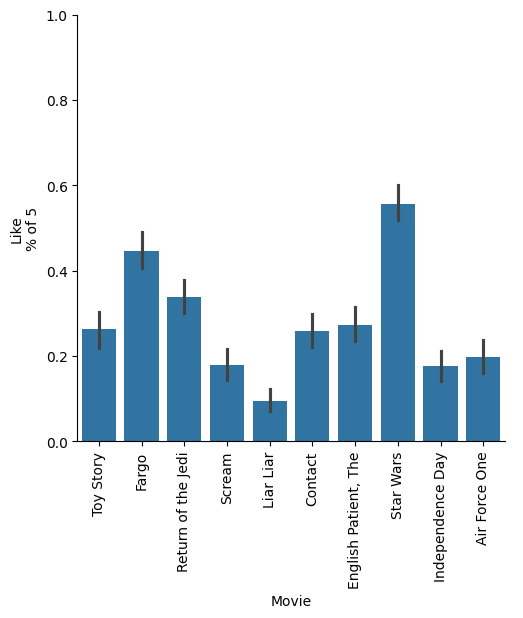

In [5]:
#Load top_n_movies_user_ratings.csv. 
#Call it movie_ratings
movie_ratings = pd.read_csv("top_n_movies_user_ratings.csv")

#Print the column names of movie_ratings; Sampled_Day: day of the month in which sampling took place (max: 30)
print(movie_ratings.columns) 

#Insert a new column in movie_ratings, call it like
#If rating == 5, like = 1, else 0
movie_ratings.insert(len(movie_ratings.columns), "like", np.array(movie_ratings.loc[:, "rating"]==5, dtype = int))

#Do now a barplot with like by movie.
#Change the labels of the y and x axis
#Change the range of the y axis i.e. ylim = (0,1)
#Rotate the x-axis labels by 90 degrees
#Comment on what you see, both the mean and error bar.
g= sns.catplot(movie_ratings, x = "movie_title", y = "like",
               kind = "bar");
g.set_xticklabels(rotation=90);
g.set(xlabel = "Movie", ylabel = "Like\n% of 5", ylim = (0,1));


#Do a chi-square test to determine if like frequencies varied by movie
#That is, test the null hypothesis that the % of 5s is identical across movies
#Tip: to obtain frequencies of like by movie use .groupby().sum()
#Tip2: use stat.chisquare() 
#Comment on the result of the test.
freq_likes_by_movie = (movie_ratings.groupby(["movie_title"]).sum()).loc[:, "like"]
freq_likes_by_movie
res = stats.chisquare(freq_likes_by_movie)
print("\nChi-square test:\n", res)

#Post-hoc tests. Test the hypothesis that Starwars is the most liked movie
#Tip: to obtain percentages of like by movie use .groupby().mean()
#Tip: to obtain n of each movie use .groupby().count()
#Use a binomial test, 10 times i.e. starwars vs each of the other movies (try to do it with a for loop) 
#Correct p values for multiple comparisons. Check if all are significant.
#Should we now recommend starwars more often? Explain
prob_likes_by_movie = (movie_ratings.groupby(["movie_title"]).mean()).loc[:, "like"]
n_by_movie = (movie_ratings.groupby(["movie_title"]).count()).loc[:, "like"]
movie_names = movie_ratings["movie_title"].unique()
pvals = []
print("\nBinomial test. Starwars vs all. Corrected p-values for multiple comparisons.\n")
for m in movie_names:
    SW_ = stats.binomtest(k = freq_likes_by_movie["Star Wars"],
                        n = n_by_movie["Star Wars"],
                        p = prob_likes_by_movie[m], alternative='two-sided')
    pvals.append(SW_.pvalue)
corrected_pvals = sm.stats.multipletests(pvals)
for idx, m in enumerate(movie_names):
    print("Starwars vs. ", m, ": ", corrected_pvals[1][idx]) 


# Advanced topic: dynamic A/B testing with reinforced learning
A continuous A/B test could be done with explore/exploit strategies overtime. This, in principle, will reduce regret faster than a traditional A/B test.

<img src="Bandit_Test.png" width="600"/>

Setup:
* Each movie "a" has an underlying value for the consumer. Call it $q(a)$
* Netflix can only guess, at each time point t, the underlying value of the movie "a". Call that guess $Q_t(a)$
* At a time t of the A/B test, each like  from a costumer (5 out of 5) is a reward signal $R_t(a)$ useful to estimate $Q_t(a)$
* One approach is to iteratively update our guess:
  
   $$Q_{t+1}(a) = Q_t(a) + \lambda(R_t(a)-Q_t(a))$$
  
  $\lambda$ is a learning rate (e.g. 0 is no learning from the reward signal)

* Note that at every time t we have a guess of the underlying value of every movie "a" i.e. $Q_t(a)$. We can decide based on that guess if we wanted.

<H2 style="text-align: center;">Dilemma</H2>
<p style="text-align: center;">Exploit ($Argmax_a Q_t(a)$)</p>
<p style="text-align: center;">vs</p>
<p style="text-align: center;">Explore (other non $Argmax$)</p>

In our problem, exploit means to start showing the other groups of the A/B experiment Netflix's guess of the best movie. Explore means to continue with the original A/B design. 

What to do? There is no clear solution but there are flexible/probabilistic policies. Some possibilites include $\epsilon - greedy$ or $softmax$.  

For instance, with $\epsilon - greedy$ we pick explore with $\epsilon$ probability and exploit with $1-\epsilon$.

What is the probability of choosing 143 with $\epsilon=0.5$?
<center><img src="MAB2.png" width = "500" height = '500'></center>

Another popular policy is to use a softmax function that maps a vector of real values to the interval [0,1]:

$$Pr\{A_t=a\} = \pi_t(a) \dot{=}  \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}$$

$H_t(a)$: Strength of preference towards option $a$ (e.g. a linear transformation of $Q_t(a)$)

How all this applies to A/B testing? It is a more dynamic and flexible approach, and could reduce the amount of regret

<img src="Bandit_Test.png" width="600"/>

Indeed, [Brian O´Gorman](https://github.com/brian-c-ogorman/ABanditTesting/) shows that multi-armed A/B testing goes faster to the optimal movie (Star Wars). Thompson is a probabilistic policy, see explanation [here](https://archive.ph/zSxhU).

<img src="pct_liked_recs.png" width="600"/>

Check his repository [repository](https://github.com/brian-c-ogorman/ABanditTesting/) for the Python implementation. But in brief, at each time point we get a reward of 1 if the sampled movie has a 5 rating, else 0. Assuming a fixed learning rate, we update the Q's using the observed reward and decide whether to exploit or explore according to the policy (e.g. $\epsilon-greedy$).

# Bayesian A/B testing

## A/B Testing (proportions)

This is perhaps the simplest and most popular experimental design. We want to determine which option is better, A or B. 

For instance, which robot should interact with clients in an Santa Fe Grill? Robot A or Robot B?

|<img src="4_CB/Robot_A.webp" width = "300" height = '300'>|<img src="4_CB/Robot_B.jpg" width = "250" height = '250'>|
|:-:|:-:|
|||

We set up an experiment at Santa Fe Grill. Two groups in different days. The size of each group is $n_1$ and $n_2$ with $k_1$ y $k_2$ counts preferring robot 1. With these data, we want to determine the latent/real proportion $\theta_1$ (%preferring robot 1) and $\theta_2$ (%preferring robot 2).

Bayesian formulation:
<center><img src="4_CB/model_ab.svg" width = "600" height = '600'></center>

In [3]:
#We do not know these proportions. They are the theta in the previous graphical model (DAG).
true_p_A = 0.09 
true_p_B = 0.04

#We have more data at site A. This is not a problem, the Bayesian setup handles it well.
N_A = 150
N_B = 75

#We generate some data. The ks in the graphical model.
datos_A = stats.bernoulli.rvs(true_p_A, size=N_A)
datos_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from days A: ", datos_A[:30], "...")
print("Obs from days B: ", datos_B[:30], "...")
print("Mean A: ", np.mean(datos_A))
print("Mean B: ", np.mean(datos_B)) 

Obs from days A:  [0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from days B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] ...
Mean A:  0.14
Mean B:  0.05333333333333334


In [4]:
# Let's formulate the model in pymc. 
# We will use uniform priors for p_A & p_B (the thetas)
with pm.Model() as model:
    
    #Priors
    p_A = pm.Beta("p_A", 1, 1) #Beta(1,1) uniform in the range 0,1
    p_B = pm.Beta("p_B", 1, 1)
    
    #Key variable: the difference in proportions.
    delta = pm.Deterministic("delta", p_A - p_B)

    # Likelihood. We assume both sampling sites are independent.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=datos_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=datos_B)

    # Sampling algorithm
    #step = pm.Metropolis() #Algorithm type.
    nsamples = 3000
    #trace = pm.sample(nsamples, step=step)
    trace = pm.sample(nsamples, chains = 4) #, target_accept = 0.8)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_A, p_B]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 49 seconds.


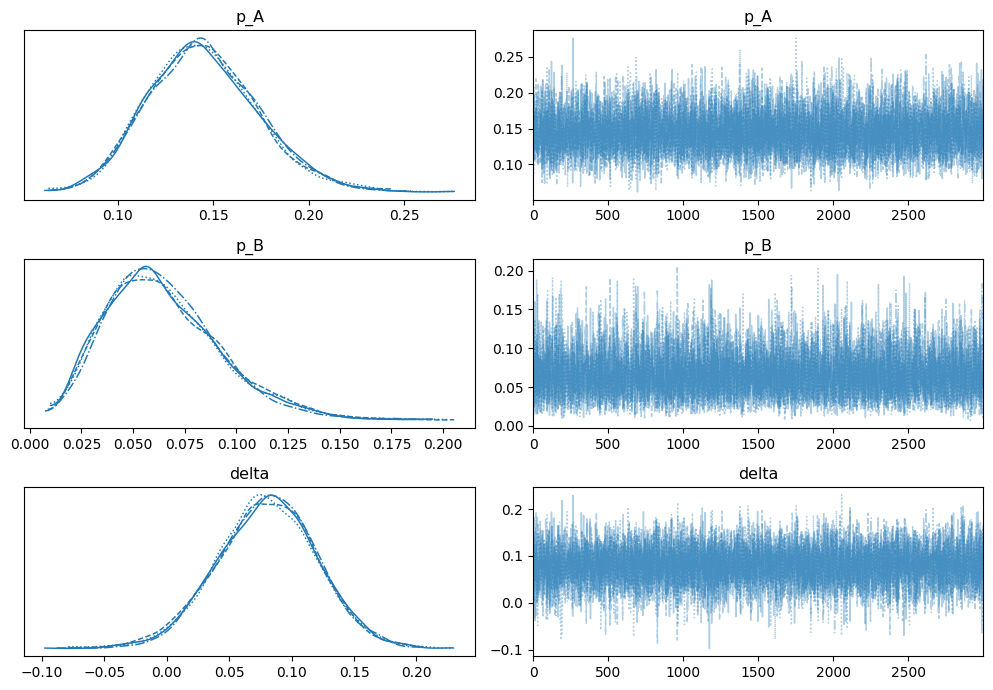

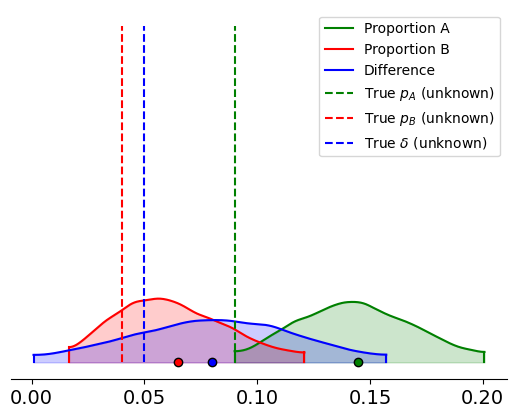

In [5]:
#Graph
s = az.extract(trace) #puts the info of the n chains together
p_A_samples = np.array(s["p_A"]) 
p_B_samples = np.array(s["p_B"])
delta_samples = np.array(s["delta"])  

#Convergence
az.plot_trace(trace, figsize = [10,7]);
plt.tight_layout()

#Densities 
az.plot_density(
    [p_A_samples,p_B_samples,delta_samples],
    data_labels = ['Proportion A', 'Proportion B', 'Difference'],
    shade=.2, colors = ['green','red','blue'] ,hdi_prob=.95, 
)
plt.vlines(true_p_A, 0, 80, linestyle="--", 
           label="True $p_A$ (unknown)", color ='green')
plt.vlines(true_p_B, 0, 80, linestyle="--", 
           label="True $p_B$ (unknown)", color ='red')
plt.vlines(true_p_A-true_p_B, 0, 80, linestyle="--", 
           label="True $\delta$ (unknown)", color ='blue')
plt.legend()
plt.title('');

Are we less confident for B or A? Why? Sample size? Sample quality?

In [6]:
print("Probability that proportion A < proportion B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability that proportion A > proportion B: %.3f" % \
    np.mean(delta_samples > 0))

Probability that proportion A < proportion B: 0.025
Probability that proportion A > proportion B: 0.975


Are these probabilities enough to decide? Debate

We just compared two proportions with a Bayesian approach.

The sample size is accounted by default in the analysis: less certainty for $p_B$

We can test questions using the posterior directly e.g. mode, areas under the curve, etc

## A/B test (means)
[Source: PyMC. Implemented in PyMC 5: Santiago Alonso](https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/case_studies/BEST.html)

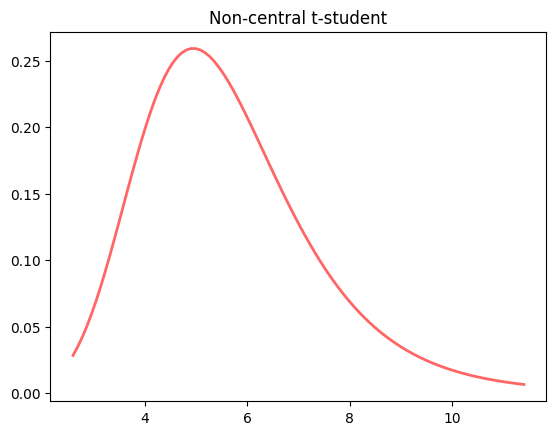

In [8]:
df, nc = 10, 5.24 #degrees of freedom and non-centrality i.e. mu
x = np.linspace(stats.nct.ppf(0.01, df, nc), #nct is for non-central t-student distributions
                stats.nct.ppf(0.99, df, nc), 100)

plt.plot(x, stats.nct.pdf(x, df, nc),
         'r-', lw=2, alpha=0.6, label='nct pdf');
plt.title("Non-central t-student");

This is the probability density function of a non-central t-student distribution:
$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$

Why non-central? Because now we estimate the difference, we do not test the null

We collect data from group A and B. The likelihood of that data we define it as a non-central t-student distribution: 
$$x^{(A)}_i \sim T(\nu, \mu_A, \sigma_1)$$
$$x^{(B)}_i \sim T(\nu, \mu_B, \sigma_2)$$

The prior for both $\mu$ is normal, with mean equal to the pooled mean of the whole sample ($\bar{x}$) and standard deviation two times the pooled standard deviation of the whole sample ($2s$)
$$\mu_k \sim N(\bar{x}, 2s)$$

We are ultimately interested in the difference of the latent means:
$$\delta = \mu_A - \mu_B$$

As for $\nu$, we assume that both groups are similar in their normality (no subscript). We assign it an exponential prior. 

$$f(x \mid \lambda) = \lambda \exp\left\{ -\lambda x \right\}$$

We set $\lambda = 1/30$ so that large $\nu$ become progressively unlikely (as $\nu$ grows the t-student is more normal):
<center><img src="4_CB/Exponential.png" width = "600" height = '600'></center>



As for $\sigma_k$, we want variation within some range, to have values within a sensitive limit

$$\sigma_k \sim Uniform(low,high)$$

In [10]:
#Let´s do the traditional t_test with the website data
AB_website_test = pd.read_csv("AB_test_group.csv", sep = ";")
AB_website_control = pd.read_csv("AB_control_group.csv", sep = ";")
cols = ["Campaign", "Date", "Cost_Campaign", "n_Impresions", "Reach", 
        "n_Clicks", "n_Searches", "n_Views", "n_Cart", "n_Purchase"]
AB_website_test.columns = cols
AB_website_control.columns = cols
AB_website = pd.concat([AB_website_test, AB_website_control]).reset_index(drop=True)
AB_website.dropna(inplace = True)
campaigns = AB_website.loc[:,"Campaign"].unique()
idx_A = (AB_website.loc[:,"Campaign"] == campaigns[0])
idx_B = (AB_website.loc[:,"Campaign"] == campaigns[1])
Group_A = AB_website.loc[idx_A,"n_Purchase"].reset_index(drop=True)
Group_B = AB_website.loc[idx_B,"n_Purchase"].reset_index(drop=True)
print("Two sample t-test: ", stats.ttest_ind(Group_A, Group_B))

Two sample t-test:  TtestResult(statistic=-0.03014479856562245, pvalue=0.9760568756579724, df=57.0)


With the frequentist t-test, there is not much to say, the p value is not significant, both groups are similar on the number of purchases.

In [11]:
#Now the bayesian test
#Stats from the whole sample
μ_m = AB_website["n_Purchase"].mean()
μ_s = 2*AB_website["n_Purchase"].std()


#Prior
σ_low = 50
σ_high = 300

with pm.Model() as model:
    #mu priors
    group1_mean = pm.Normal("group1_mean", mu=μ_m, sigma=μ_s)
    group2_mean = pm.Normal("group2_mean", mu=μ_m, sigma=μ_s)
    
    #sigma priors
    group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)
    #group_std = pm.Uniform("group_std", lower=σ_low, upper=σ_high)
    
    
    #nu prior
    ν = pm.Exponential("ν_minus_one", 1 / 29) + 1 #to make sure is not 0 and at least 1
    #ν = pm.Uniform("ν", lower = 100, upper = 200)
    
    #likelihood
    group1 = pm.StudentT("Group_A", nu=ν, mu=group1_mean, sigma=group1_std, 
                         observed=Group_A)
    group2 = pm.StudentT("Group_B", nu=ν, mu=group2_mean, sigma=group2_std, 
                         observed=Group_B)

    #group1 = pm.StudentT("Group_A", nu=ν, mu=group1_mean, sigma=group_std, 
    #                     observed=Group_A)
    #group2 = pm.StudentT("Group_B", nu=ν, mu=group2_mean, sigma=group_std, 
    #                     observed=Group_B)
    
    #Variables of interest
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
    )
    #effect_size = pm.Deterministic(
    #    "effect size", diff_of_means / np.sqrt((group_std ** 2 + group_std ** 2) / 2)
    #)

    trace = pm.sample(2000, chains = 4, tune = 1000)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group1_mean, group2_mean, group1_std, group2_std, ν_minus_one]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.


In [ ]:
#Convergence
az.plot_trace(trace, figsize = [10,7]);
plt.tight_layout()

In [ ]:
az.plot_posterior(
    trace,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

The Bayesian t test gives a similar answer but with more nuances. 

* The distributions provide us with a direct measure of uncertainty about the difference in means, not only about the null.

* The difference in means favors by a bit the control campaign. If a decision HAS to be made, the posterior prob. advantage is a criteria.

* The test campaign seemed more erratic, the posterior probability indicates a higher probability of a larger standard deviation.

* The difference in effect sizes, which already accounts for standard deviations, also favors slightly the control campaign. Again, this differences in high stress or in limited time could be useful.

